## Baseband PAM

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, convolve

# Parameters
N = 10**4  # Number of symbols
fs = 10    # Samples per symbol

# Generate PAM-4 symbols: ±1, ±3
bits = np.random.randint(0, 4, N)
am = 2 * bits - 3  # Maps to [-3, -1, 1, 3]

# Normalize to unit energy
# For PAM-4 with {±1, ±3}, average symbol energy = (1^2 + 1^2 + 3^2 + 3^2)/4 = 5
am = am / np.sqrt(5)  # Normalize by sqrt of average symbol energy


### Pulse shaping filter

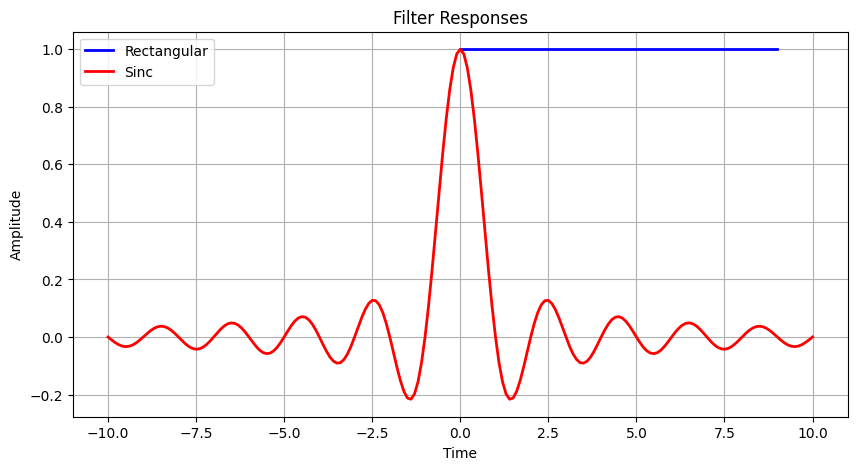

In [9]:

# Rectangular filter
gt_rectangular = np.ones(fs)

# Sinc filter
t = np.arange(-fs, fs + 1/fs, 1/fs)
gt_sinc = np.sinc(t)  # np.sinc(x) = sin(pi*x)/(pi*x)


# Plot filter responses
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(gt_rectangular)), gt_rectangular, 'b-', linewidth=2, label='Rectangular')
plt.plot(t, gt_sinc, 'r-', linewidth=2, label='Sinc')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filter Responses')
plt.grid(True)
plt.legend()
plt.show()


### Transmit signal

In [10]:
# Upsample
am_upsampled = np.zeros(N * fs, dtype=complex)
am_upsampled[::fs] = am

# Filter
st_rectangular = convolve(am_upsampled, gt_rectangular, mode='full')
st_sinc = convolve(am_upsampled, gt_sinc, mode='full')

# Check symbol closeness using numpy assertions
# For rectangular filter
recovered_rect = st_rectangular[fs-1::fs][:N]
np.testing.assert_allclose(recovered_rect, am, rtol=1e-10, 
                          err_msg="Rectangular filtered signal doesn't match original")
print("Rectangular filter: Signal recovery verified ✓")

# For sinc filter (accounting for group delay)
recovered_sinc = st_sinc[fs*fs::fs][:N]
np.testing.assert_allclose(recovered_sinc, am, rtol=1e-10,
                          err_msg="Sinc filtered signal doesn't match original")
print("Sinc filter: Signal recovery verified ✓")


# Check symbels for inter symbol interference (ISI)
err_rectangular = st_rectangular[fs-1::fs][:N] - am
err_rectangular_sum = np.sum(np.abs(err_rectangular)**2) / N

err_sinc = st_sinc[fs*fs::fs][:N] - am  # account for group delay
err_sinc_sum = np.sum(np.abs(err_sinc)**2) / N
print(f"errRectSum = {err_rectangular_sum:.3e}")
print(f"errSincSum = {err_sinc_sum:.3e}")



Rectangular filter: Signal recovery verified ✓
Sinc filter: Signal recovery verified ✓
errRectSum = 0.000e+00
errSincSum = 4.225e-27


### Power Spectral Density (PSD) plots

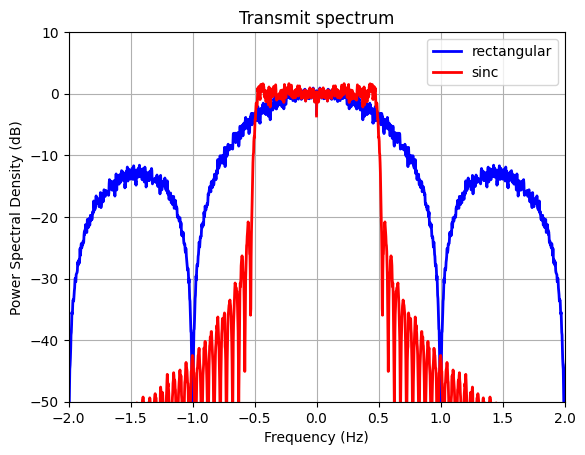

In [11]:

# PSD plots
f_rectangular, Pxx_rectangular = welch(st_rectangular, fs=fs, nperseg=4096, return_onesided=False)
f_sinc, Pxx_sinc = welch(st_sinc, fs=fs, nperseg=4096, return_onesided=False)

plt.plot(f_rectangular, 10 * np.log10((Pxx_rectangular)), 'b-',label='rectangular', linewidth=2)
plt.plot(f_sinc, 10 * np.log10((Pxx_sinc)), 'r-', label='sinc', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Transmit spectrum')
plt.legend()
plt.grid(True)
plt.xlim([-2, 2])
plt.ylim([-50, 10])
plt.show()
